# Expirements On the Dimensionality of StyleGAN Intermidate Layers

## Setup

In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install --upgrade matplotlib

In [ ]:
#setup some environments (Do not change any of the following)
import sys
import pickle
import os
import numpy as np
from IPython.display import Image
import PIL.Image
from PIL import Image
import matplotlib.pyplot as plt

import torch

sys.path.insert(0, "/content/stylegan2-ada") #do not remove this line

# import dnnlib
# import dnnlib.tflib as tflib
import IPython.display
from google.colab import files

activation_dir = '/content/activations'

In [ ]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [ ]:
%cd /content
!git clone https://github.com/dvschultz/stylegan2-ada-pytorch/
!git clone https://github.com/rosinality/stylegan2-pytorch
!pip install ninja

### Exporting StyleGAN2-ADA pretrained weights

In [ ]:
pretrained_model_path = "/content/SG2_ADA_pretrained.pkl"

%cd /content/stylegan2-ada-pytorch/
!python export_weights.py https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl $pretrained_model_path

%cd /content/stylegan2-pytorch/

/content/stylegan2-ada-pytorch
/content/stylegan2-pytorch


## Singular Values Plots


In [ ]:
def plot_sigular_vals(title, sv, y_scale='linear', filename=''):
  s_vals = range(len(sv))

  fig, ax = plt.subplots()
  ax.set_yscale(y_scale)
  ax.plot(s_vals, sv)
  ax.set_xlabel('Index (Descending)')
  ax.set_ylabel('Singular Value')
  fig.suptitle(title, fontsize=14)
  fig.set_size_inches(8, 5)
  if filename != '':
    plt.savefig(f'/content/plots/{filename}.png')
  plt.show()


def plot_cum_variance_by_svdval(title, var_explained, y_scale='linear', filename=''):
  cumsum = torch.cumsum(var_explained, dim=0)
  ninty_index = np.argmax(cumsum>0.9)
  ninty_nine_index = np.argmax(cumsum>0.99)
  extraticks = [ninty_index, ninty_nine_index]
  s_vals = range(len(var_explained))

  fig, ax = plt.subplots()
  ax.set_yscale(y_scale)
  ax.plot(s_vals, cumsum, label='Cumulative Variance')
  ax.set_xticks(list(ax.get_xticks()) + extraticks)
  ax.vlines(ninty_index, ymin=0, ymax=1, colors='orange', ls='--', lw=2, label='90% Variance')
  ax.vlines(ninty_nine_index, ymin=0, ymax=1, colors='red', ls='--', lw=2, label='99% Variance')
  ax.set_xlabel('Singular Value')
  ax.set_ylabel('Cumulative Variance Explained')
  ax.legend()
  fig.suptitle(title, fontsize=14)
  fig.set_size_inches(8, 5)
  if filename != '':
    plt.savefig(f'/content/plots/{filename}.png')
  plt.show()


def plot_cum_variances_by_svdval(title, vars_explained, y_scale='linear', filename=''):

  fig, ax = plt.subplots()
  ax.set_yscale(y_scale)
  for i, var_explained in enumerate(vars_explained):
    cumsum = torch.cumsum(var_explained, dim=0)
    # ninty_index = np.argmax(cumsum>0.9)
    # ninty_nine_index = np.argmax(cumsum>0.99)
    # extraticks = [ninty_index, ninty_nine_index]
    s_vals = range(len(var_explained))
    ax.plot(s_vals, cumsum, label=f'Layer {i}')
  
  #ax.set_xticks(list(ax.get_xticks()))
  # ax.vlines(ninty_index, ymin=0, ymax=1, colors='orange', ls='--', lw=2, label='90% Variance')
  # ax.vlines(ninty_nine_index, ymin=0, ymax=1, colors='red', ls='--', lw=2, label='99% Variance')
  ax.set_xlabel('Singular Value')
  ax.set_ylabel('Cumulative Variance Explained')
  ax.legend()
  fig.suptitle(title, fontsize=14)
  fig.set_size_inches(8, 5)
  if filename != '':
    plt.savefig(f'/content/plots/{filename}.png')
  plt.show()


def plot_variance_by_svdval(title, var_explained, y_scale='linear', filename=''):
  ymax = torch.max(var_explained).item()
  cumsum = torch.cumsum(var_explained, dim=0)
  ninty_index = np.argmax(cumsum>0.9)
  ninty_nine_index = np.argmax(cumsum>0.99)
  extraticks = [ninty_index, ninty_nine_index]
  s_vals = range(len(var_explained))

  fig, ax = plt.subplots()
  ax.set_yscale(y_scale)
  ax.plot(s_vals, var_explained, label='Variance')
  ax.set_xticks(list(ax.get_xticks()) + extraticks)
  ax.vlines(ninty_index, ymin=0, ymax=ymax, colors='orange', ls='--', lw=2, label='90% Variance')
  ax.vlines(ninty_nine_index, ymin=0, ymax=ymax, colors='red', ls='--', lw=2, label='99% Variance')
  ax.set_xlabel('Singular Value')
  ax.set_ylabel('Variance Explained')
  ax.legend()
  fig.suptitle(title, fontsize=14)
  fig.set_size_inches(8, 5)
  if filename != '':
    plt.savefig(f'/content/plots/{filename}.png')
  plt.show()


def plot_cum_variance_by_svdval_comparison(title, var_explained_a, var_explained_w, y_scale='linear', filename=''):
  num_layers = len(var_explained_a)
  fig, axs = plt.subplots(2, num_layers//2, figsize=(8*(num_layers// 2), 2*4))
  for i in range(num_layers):
    ax = axs[i% 2, i // 2]
    s_vals = range(len(var_explained_a[i]))
    cumsum_a = torch.cumsum(var_explained_a[i], dim=0)
    ninty_index_a = np.argmax(cumsum_a>0.9)
    ninty_nine_index_a = np.argmax(cumsum_a>0.99)
    cumsum_w = torch.cumsum(var_explained_w[i], dim=0)
    ninty_index_w = np.argmax(cumsum_w>0.9)
    ninty_nine_index_w = np.argmax(cumsum_w>0.99)
    # extraticks = [ninty_index_a, ninty_nine_index_a, ninty_index_w, ninty_nine_index_w]
    # ax.set_xticks(extraticks, minor=True)
    # ax.tick_params( axis='x', which='minor', direction='out', length=6, pad=15)
    # ax.set_xticklabels(labels=[str(v.item()) for v in extraticks], minor=True)
    # ax.tick_params( axis='x', which='major', bottom='off', top='off' )

    ax.set_yscale(y_scale)
    ax.plot(s_vals, cumsum_w, label='Weights')
    ax.plot(s_vals, cumsum_a, label='Activations')
    ax.set_xticks(list(ax.get_xticks()))# + extraticks)
    ax.vlines(ninty_index_w, ymin=0, ymax=1.05, colors='orange', ls='--', lw=2, label='Weights - 90%')
    ax.vlines(ninty_nine_index_w, ymin=0, ymax=1.05, colors='red', ls='--', lw=2, label='Weights - 99%')
    ax.vlines(ninty_index_a, ymin=0, ymax=1.05, colors='purple', ls='--', lw=2, label='Activations - 90%')
    ax.vlines(ninty_nine_index_a, ymin=0, ymax=1.05, colors='brown', ls='--', lw=2, label='Activations - 99%')
    ax.title.set_text(f'Layer {i+1}')
  
  # fig.suptitle(title, fontsize=14)
  fig.supxlabel('Components Retained', y=0.05)
  fig.supylabel('Cumulative Variance Explained (%)', x=0.08)
  handles, labels = ax.get_legend_handles_labels()
  fig.legend(handles, labels, bbox_to_anchor=(0.5, 0), loc="lower center",
                bbox_transform=fig.transFigure, ncol=6)
  
  if filename != '':
    plt.savefig(f'/content/plots/{filename}.png')
  plt.show()

## Dimensionality of Convolutional Filters

In [ ]:
#@title Loading the Generator Model

from model import Generator, StyledConv

pretrained_model_path = "/content/SG2_ADA_pretrained.pkl"
pretrained_model = torch.load(pretrained_model_path)
G_ema = Generator(size=1024, style_dim=512, n_mlp=8).to(device)
G_ema.load_state_dict(pretrained_model["g_ema"])
G_ema.eval()

In [ ]:
conv1_weights = G_ema.conv1.conv.weight.detach()
conv1_weights.squeeze()
conv1_filter_mat = torch.flatten(conv1_weights.squeeze(), start_dim=1, end_dim=3)
S = torch.linalg.svdvals(conv1_filter_mat)
var_explained = torch.round(S**2/torch.sum(S**2), decimals=5).cpu()

In [ ]:
var_by_layer = []
for i, layer in enumerate(G_ema.convs):
  conv_weights = layer.conv.weight.detach()
  conv_filter_mat = torch.flatten(conv_weights.squeeze(), start_dim=1, end_dim=3)
  S = torch.linalg.svdvals(conv_filter_mat)
  var_explained = torch.round(S**2/torch.sum(S**2), decimals=5).cpu()
  var_by_layer.append(var_explained)

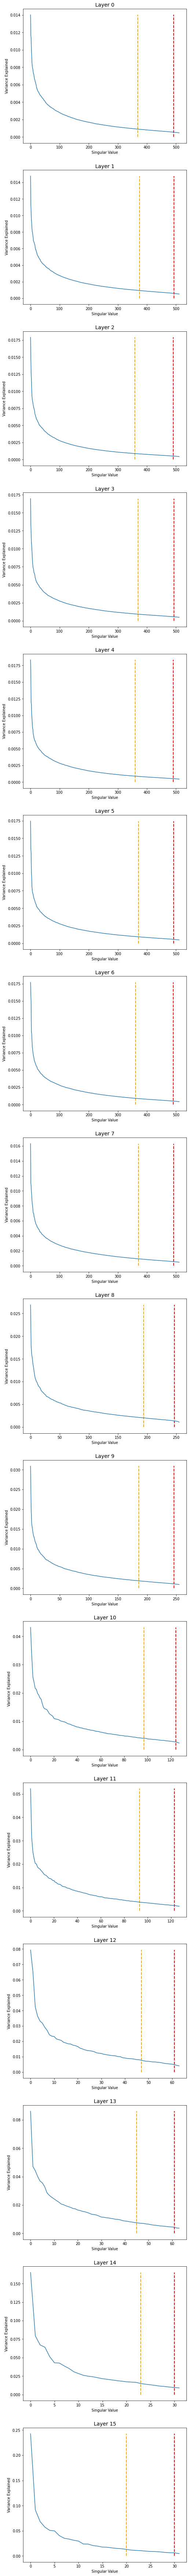

In [ ]:
# plt.subplots_adjust(hspace=1.2)
fig, axs = plt.subplots(len(var_by_layer))
fig.set_size_inches(8, 8*len(var_by_layer))
# fig.suptitle('Weights Variance by Singular Values')

for i, var_explained in enumerate(var_by_layer):
  cumsum = torch.cumsum(var_explained, dim=0)
  ninty_index = np.argmax(cumsum>0.9)
  ninty_nine_index = np.argmax(cumsum>0.99)
  extraticks = [ninty_index, ninty_nine_index]
  
  s_vals = range(len(var_explained))
  y_max = torch.max(var_explained)
  axs[i].plot(s_vals, var_explained)
  axs[i].vlines(ninty_index, ymin=0, ymax=y_max, colors='orange', ls='--', lw=2, label='90%')
  axs[i].vlines(ninty_nine_index, ymin=0, ymax=y_max, colors='red', ls='--', lw=2, label='99%')
  axs[i].set_xlabel('Singular Value')
  axs[i].set_ylabel('Variance Explained')
  axs[i].set_title(f'Layer {i}', fontsize=14)

plt.savefig(f'/content/plots/weight_variances.png')

## Generating the activations

### Running the Generator

In [ ]:
%cd /content/stylegan2-pytorch/

/content/stylegan2-pytorch


In [ ]:
from model import Generator, StyledConv

pretrained_model_path = "/content/SG2_ADA_pretrained.pkl"
pretrained_model = torch.load(pretrained_model_path)
G_ema = Generator(size=1024, style_dim=512, n_mlp=8).to(device)
G_ema.load_state_dict(pretrained_model["g_ema"])
G_ema.eval()

In [ ]:
#@title ZCA

from torch import matmul as mm

def zca_encode(X, U, mean=None, n_components=0):
  if n_components != 0:
    U = U[:,:n_components]
  else:
    n_components = min(U.shape[0], U.shape[1])
  
  if mean != None:
    X_centered = X - mean

  return mm(U.T, X_centered)


def zca_decode(X_rot, U, mean=None, n_components=0):
  if n_components != 0:
    U = U[:,:n_components]
  else:
    n_components = min(U.shape[0], U.shape[1])
  
  X_dec = mm(U, X_rot)

  if mean != None:
    #mistake in sklearn pca?
    # padding = torch.zeros((X.shape[0] - n_components, mean.shape[1]), device=device)
    # mean_reduced = torch.cat((mean[:n_components], padding), dim=0)
    X_dec = X_dec + mean
  
  return X_dec


def zca_enc_dec(X, U, mean=None, n_components=0):
  X_rot = zca_encode(X, U, mean, n_components)  
  return zca_decode(X_rot, U, mean, n_components)
  
  # out = X.reshape(1, -1).cpu()
  # out = U.transform(out)
  # out = U.inverse_transform(out)
  # return torch.tensor(out, dtype=torch.float ,device=device)


def perform_zca(activation, U, truncated_dim=0):
  shape = activation.shape
  flat = activation.squeeze().flatten(start_dim=1)
  after = zca_enc_dec(flat, U, truncated_dim)
  zca_err = torch.norm(flat-after)
  out = after.reshape(shape)
  return out, zca_err

In [ ]:
#@title Generating Activations

from pathlib import Path

def save_activation(activation, image_idx, layer_idx, activation_dir):
  p = Path(f'{activation_dir}/{layer_idx}/')
  p.mkdir(parents=True, exist_ok=True)
  torch.save(activation, p.joinpath(f'{str(image_idx).zfill(6)}.pt'))


def forward_and_save_activation(styledconv_layer, layer_idx, input, style, noise, image_idx, activation_dir):
  out = styledconv_layer(input, style)
  save_activation(out, image_idx, layer_idx, activation_dir)
  out = styledconv_layer.noise(out, noise=noise)
  # out = out + self.bias
  out = styledconv_layer.activate(out)
  return out

def generator_forward(
    generator,
    styles,
    return_latents=False,
    inject_index=None,
    truncation=1,
    truncation_latent=None,
    input_is_latent=False,
    noise=None,
    randomize_noise=False,
    save_activations=[],
    activation_dir='/content/activations',
    end_layer = -1,
    zca_index = -1,
    zca_mat = None,
    image_idx = -1
):
    if not input_is_latent:
        styles = [generator.style(s) for s in styles]

    if noise is None:
        if randomize_noise:
            noise = [None] * generator.num_layers
        else:
            noise = [
                getattr(generator.noises, f"noise_{i}") for i in range(generator.num_layers)
            ]

    if truncation < 1:
        style_t = []

        for style in styles:
            style_t.append(
                truncation_latent + truncation * (style - truncation_latent)
            )

        styles = style_t

    if len(styles) < 2:
        inject_index = generator.n_latent

        if styles[0].ndim < 3:
            latent = styles[0].unsqueeze(1).repeat(1, inject_index, 1)

        else:
            latent = styles[0]

    else:
        if inject_index is None:
            inject_index = random.randint(1, generator.n_latent - 1)

        latent = styles[0].unsqueeze(1).repeat(1, inject_index, 1)
        latent2 = styles[1].unsqueeze(1).repeat(1, generator.n_latent - inject_index, 1)

        latent = torch.cat([latent, latent2], 1)

    out = generator.input(latent)
    out = generator.conv1(out, latent[:, 0], noise=noise[0])

    skip = generator.to_rgb1(out, latent[:, 1])

    end_index = end_layer if end_layer != -1 else len(generator.convs)
    zca_err = None

    i = 1
    for conv1, conv2, noise1, noise2, to_rgb in zip(
        generator.convs[:end_index:2], generator.convs[1:end_index:2], noise[1:end_index+1:2], noise[2:end_index+1:2], generator.to_rgbs
    ):
        if i in save_activations:
          out = forward_and_save_activation(conv1, i, out, latent[:, i], noise1, image_idx, activation_dir)
        else:
          out = conv1(out, latent[:, i], noise=noise1)

        if i == zca_index:
          out, zca_err = perform_zca(out, zca_mat)

        if i in save_activations:
          out = forward_and_save_activation(conv2, i+1, out, latent[:, i+1], noise2, image_idx, activation_dir)
        else:
          out = conv2(out, latent[:, i + 1], noise=noise2)

        if i+1 == zca_index:
          out, zca_err = perform_zca(out, zca_mat)

        skip = to_rgb(out, latent[:, i + 2], skip)

        i += 2

    image = skip


    if return_latents:
        return image, latent, zca_err

    else:
        return image, None, zca_err

In [ ]:
#@title Running an Expirement

import torch
from torchvision import utils
from tqdm import tqdm

def run_generator_expirement(pics, end_layer,
                             activations_to_save=[], activation_dir='\content\activations',
                             return_latents=True,
                             input_is_latent = False,
                             latents = None,
                             zca_index = -1, zca_mat = None,
                             start_index=0,
                             output_dir='sample'):

  args = {
    'size': 1024,
    'sample': 1,
    'truncation': 1,
    'truncation_mean': 4096,
    'channel_multiplier': 2,
    'latent': 512,
    'n_mlp': 8,
    'pics': pics
  }
  mean_latent = None
  
  Path(output_dir).mkdir(parents=True, exist_ok=True)

  with torch.no_grad():
      latent_array = []
      zca_err_by_idx = []
      G_ema.eval()

      for i in tqdm(range(args['pics'])):
          if latents == None:
            style_input = torch.randn(args['sample'], args['latent'], device=device)
          else:
            style_input = latents[i]

          sample, latent, zca_err = generator_forward(
              G_ema, [style_input], truncation=args['truncation'], truncation_latent=mean_latent,
              image_idx = i+start_index,
              return_latents=return_latents,
              input_is_latent=input_is_latent,
              end_layer=end_layer,
              save_activations=activations_to_save,
              activation_dir=activation_dir,
              zca_index=zca_index, zca_mat=zca_mat
          )

          latent_array.append(latent)
          zca_err_by_idx.append(zca_err)
          # if i % 100 == 0:
          #   torch.save(_, f'./latents/{str(i).zfill(6)}.pt')

          utils.save_image(
              sample,
              f"{output_dir}/{str(i).zfill(6)}.png",
              nrow=1,
              normalize=True,
              range=(-1, 1),
          )
      return latent_array, zca_err_by_idx

In [ ]:
activations_to_save = [1, 2, 3, 4]
z_array, zca_err_by_idx = run_generator_expirement(2048, 5, activations_to_save, activation_dir)

  0%|          | 0/2048 [00:00<?, ?it/s]/content/stylegan2-pytorch/op/conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 1.13.1+cu116. Falling back to torch.nn.functional.conv2d().
  warnings.warn(
100%|██████████| 2048/2048 [00:34<00:00, 58.52it/s]


In [ ]:
test_activation_dir = '/content/test_activations'
activations_to_save = [1, 2, 3, 4]
latent_arr, _ = run_generator_expirement(512, 5, activations_to_save, test_activation_dir,
                                                   return_latents=True,
                                                   output_dir="test_sample")

100%|██████████| 512/512 [00:06<00:00, 75.39it/s]


In [ ]:
#@title Saving the activations

latent_dir = '/content/latents'

def save_latents(z_array, latent_dir, run_name='latents'):
  Path(latent_dir).mkdir(parents=True, exist_ok=True)
  cat = torch.cat(z_array)
  torch.save(cat, f'{latent_dir}/{run_name}.pt')

save_latents(z_array, latent_dir, 'full_2048_pca')

In [ ]:
#@title Loading Activation Files
def load_activation_mat(activation_dir, layer_idx, num_samples=0):
  activation_paths = [ f.path for f in os.scandir(f'{activation_dir}/{layer_idx}') if f.is_file() ]
  if num_samples == 0: num_samples = len(activation_paths)
  (l_dim, spatial_size) = torch.load(activation_paths[0]).squeeze().flatten(start_dim=1).shape
  activation_mat = torch.zeros(l_dim, num_samples*spatial_size)
  for i, path in enumerate(activation_paths[:num_samples]):
    activation = torch.load(path)
    activation_mat[:,i*spatial_size : (i+1)*spatial_size] = activation.squeeze().flatten(start_dim=1)
  
  return activation_mat

## Computing the PCA Transformation of the Activations

In [ ]:
l_indices = [1, 2, 3, 4]

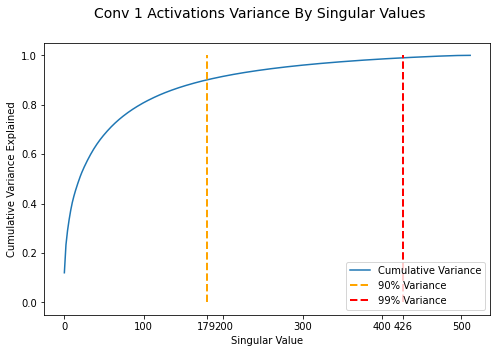

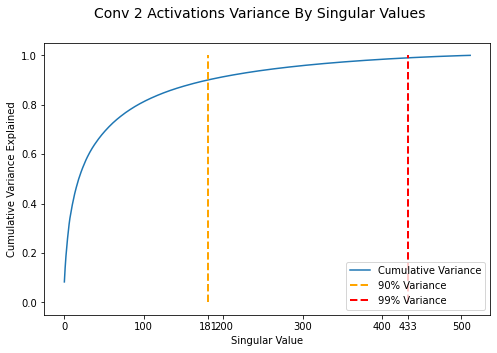

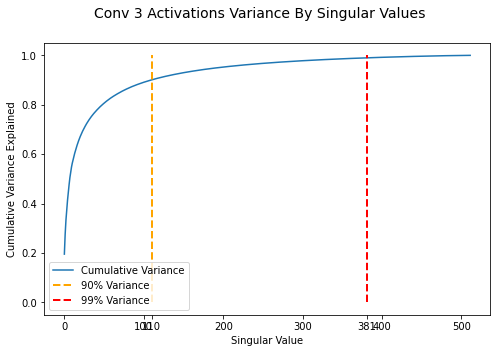

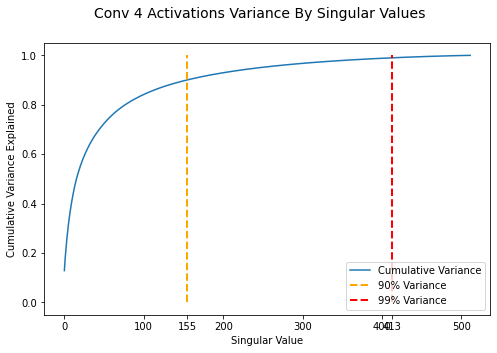

In [ ]:
#@title Computing the PCA using sklearn

import numpy as np
from sklearn.decomposition import IncrementalPCA
from sklearn.decomposition import TruncatedSVD

n_components = 512

pca_by_layer = []

for layer_idx in range(1,len(l_indices)+1):
  activation_mat = load_activation_mat(activation_dir, layer_idx)
  activation_mat = activation_mat.T.cpu()
  #TODO: implement a dynamic batch size
  batch_size = activation_mat.shape[1]*256
  pca = IncrementalPCA(n_components, batch_size=batch_size)
  pca.fit(activation_mat)
  pca_by_layer.append(pca)

  plot_title = f'Conv {layer_idx} Activations Variance By Singular Values'
  plot_cum_variance_by_svdval(plot_title, torch.tensor(pca.explained_variance_ratio_) , y_scale='linear')

del activation_mat

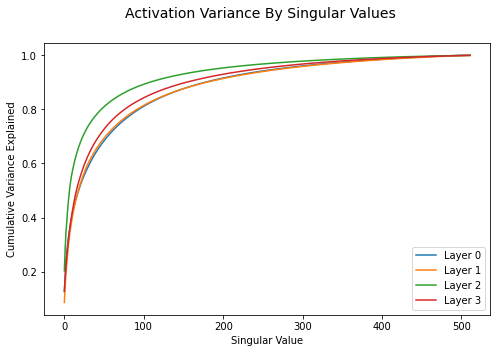

In [ ]:
var_explained_a = [torch.tensor(pca.explained_variance_ratio_) for pca in pca_by_layer]
vars_explained = [torch.tensor(l_pca.explained_variance_ratio_) for l_pca in pca_by_layer]
plot_title = f'Activation Variance By Singular Values'
plot_cum_variances_by_svdval(plot_title, vars_explained, 'linear', 'cum_vars_explained')

In [ ]:
#@title Persisting the SVD 
from pathlib import Path

for i, pca in enumerate(pca_by_layer):
  p = Path(f'/content/pca_by_layer/{i}')
  p.mkdir(parents=True, exist_ok=True)
  torch.save(torch.tensor(pca.components_, dtype=torch.float), p.joinpath(f'layer_{i}_U.pt'))
  torch.save(torch.tensor(pca.singular_values_, dtype=torch.float), p.joinpath(f'layer_{i}_S.pt'))

### ZCA Error by Components Retained

In [ ]:
#@title Computing ZCA L2- Loss by Components

import gc
from torch.linalg import norm
from sklearn.decomposition import PCA

err_by_layer_by_ncomp_fine = {}
# err_by_layer_by_ncomp_fine[512] = test_zca_err

num_samples = 512
n_components_list_fine = [512, 450, 400, 350, 300, 200, 100, 10]


# TODO: Possible bug, implement dynamic layer ranges
for layer_idx in range(1, len(l_indices)+1):
  l_pca = pca_by_layer[layer_idx-1]
  U_full = torch.tensor(l_pca.components_[:n_components_list_fine[0]], dtype=torch.float, device=device).T
  X = load_activation_mat('/content/test_activations', layer_idx, num_samples).to(device)
  mean_full = torch.tensor(l_pca.mean_, dtype=torch.float, device=device).view(-1,1)
  X_rot_full = zca_encode(X, U_full, mean_full)
  
  for n_comp in n_components_list_fine:
    reduced = zca_decode(X_rot_full[:n_comp], U_full[:,:n_comp], mean_full)
    
    diff = X - reduced
    spatial = X.shape[1] // num_samples
    X_split = torch.stack(list(torch.tensor_split(X, num_samples, dim=1)), dim=0)
    diff_split = torch.stack(list(torch.tensor_split(diff, num_samples, dim=1)), dim=0)
    err_by_sample = [norm(d).item() for d in diff_split]
    rel_err_by_sample = [(err_by_sample[i] / (norm(s).item())) for i, s in enumerate(X_split) ]
    err = np.mean(err_by_sample)
    rel_err = np.mean(rel_err_by_sample)
    zca_err_by_layer = err_by_layer_by_ncomp_fine.get(n_comp, [])
    zca_err_by_layer.append((err, rel_err))
    err_by_layer_by_ncomp_fine[n_comp] = zca_err_by_layer

    torch.cuda.empty_cache()
    gc.collect()
    print(f'Layer: {layer_idx}, n_components: {n_comp}:')
    print(f'Error: {err}')
    print(f'Cuda mem: {torch.cuda.memory_allocated()}')


In [ ]:
def plot_zca_rel_err_by_layer_and_ncomp(l_indices, n_components_list, err_by_layer_by_ncomp):

  x = np.arange(len(l_indices))  # the label locations
  width = 0.125  # the width of the bars
  multiplier = 0

  fig, ax = plt.subplots(constrained_layout=False)
  fig.set_size_inches(15, 5)

  for n_comp, err_by_layer in err_by_layer_by_ncomp.items():
    offset = width * multiplier
    rel_err_by_layer = [tup[1] for tup in err_by_layer]
    train_rects = ax.bar(x + offset, rel_err_by_layer, width, label=str(n_comp))
    ax.bar_label(train_rects, labels=['{:.2f}'.format(val) for val in rel_err_by_layer], padding=3)
    multiplier += 1

  # Add some text for labels, title and custom x-axis tick labels, etc.
  ax.set_ylabel('Relative Error (%)')
  ax.set_yscale('linear')
  ax.set_title('ZCA Error By Convolutional Layer')
  ax.set_xticks(x + (width * (len(err_by_layer_by_ncomp) -1))/2, range(1, len(l_indices) + 1))
  ax.legend(loc='upper left')
  plt.savefig('/content/plots/zca_rel_err_by_n_components.png')
  plt.show()

  def plot_zca_err_by_layer_and_ncomp(l_indices, n_components_list, err_by_layer_by_ncomp):

  x = np.arange(len(l_indices))  # the label locations
  width = 0.125  # the width of the bars
  multiplier = 0

  fig, ax = plt.subplots(constrained_layout=False)
  fig.set_size_inches(15, 5)

  for n_comp, err_by_layer in err_by_layer_by_ncomp.items():
    offset = width * multiplier
    rel_err_by_layer = [tup[0] for tup in err_by_layer]
    train_rects = ax.bar(x + offset, rel_err_by_layer, width, label=str(n_comp))
    ax.bar_label(train_rects, labels=['{:.2f}'.format(val) for val in rel_err_by_layer], padding=3)
    multiplier += 1

  # Add some text for labels, title and custom x-axis tick labels, etc.
  ax.set_ylabel('L2 Reconstruction Error')
  ax.set_yscale('linear')
  ax.set_title('ZCA Error By Convolutional Layer')
  ax.set_xticks(x + (width * (len(err_by_layer_by_ncomp) -1))/2, range(1, len(l_indices) + 1))
  ax.legend(loc='upper left')
  plt.savefig('/content/plots/zca_err_by_n_components.png')
  plt.show()

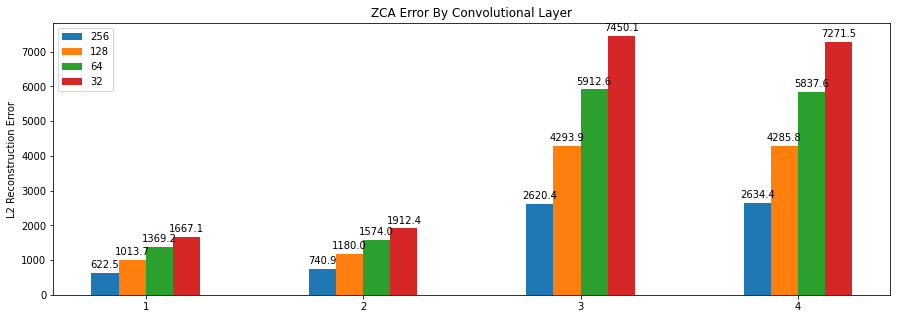

In [ ]:
percent_err_by_layer_by_ncomp = {key: [(err[0], 100*err[1]) for err in errs] for key, errs in err_by_layer_by_ncomp.items()}
plot_zca_rel_err_by_layer_and_ncomp(l_indices, n_components_list, percent_err_by_layer_by_ncomp)
plot_zca_err_by_layer_and_ncomp(l_indices, n_components_list, percent_err_by_layer_by_ncomp)

In [ ]:
#@title Compute ZCA L2- Train Error by Components

import gc
from torch.linalg import norm
from sklearn.decomposition import PCA

train_err_by_layer_by_ncomp_fine = {}
# err_by_layer_by_ncomp_fine[512] = test_zca_err

num_samples = 512
n_components_list_fine = [512, 450, 400, 350, 300, 200, 100, 10]


# TODO: Possible bug, implement dynamic layer ranges
for layer_idx in range(1, len(l_indices)+1):
  l_pca = pca_by_layer[layer_idx-1]
  U_full = torch.tensor(l_pca.components_[:n_components_list_fine[0]], dtype=torch.float, device=device).T
  X = load_activation_mat(activation_dir, layer_idx, num_samples).to(device)
  mean_full = torch.tensor(l_pca.mean_, dtype=torch.float, device=device).view(-1,1)
  X_rot_full = zca_encode(X, U_full, mean_full)
  
  for n_comp in n_components_list_fine:
    reduced = zca_decode(X_rot_full[:n_comp], U_full[:,:n_comp], mean_full)
    
    diff = X - reduced
    spatial = X.shape[1] // num_samples
    X_split = torch.stack(list(torch.tensor_split(X, num_samples, dim=1)), dim=0)
    diff_split = torch.stack(list(torch.tensor_split(diff, num_samples, dim=1)), dim=0)
    err_by_sample = [norm(d).item() for d in diff_split]
    rel_err_by_sample = [(err_by_sample[i] / (norm(s).item())) for i, s in enumerate(X_split) ]
    err = np.mean(err_by_sample)
    rel_err = np.mean(rel_err_by_sample)
    zca_err_by_layer = train_err_by_layer_by_ncomp_fine.get(n_comp, [])
    zca_err_by_layer.append((err, rel_err))
    train_err_by_layer_by_ncomp_fine[n_comp] = zca_err_by_layer

    torch.cuda.empty_cache()
    gc.collect()
    print(f'Layer: {layer_idx}, n_components: {n_comp}:')
    print(f'Error: {err}')
    print(f'Cuda mem: {torch.cuda.memory_allocated()}')


Layer: 1, n_components: 512:
Error: 7.709115880771833e-05
Cuda mem: 2242558464
Layer: 1, n_components: 450:
Error: 9.046469058841467
Cuda mem: 1168816640
Layer: 1, n_components: 400:
Error: 13.870344316586852
Cuda mem: 900381184
Layer: 1, n_components: 350:
Error: 18.289909079670906
Cuda mem: 1168816640
Layer: 1, n_components: 300:
Error: 22.75386859662831
Cuda mem: 900381184
Layer: 1, n_components: 200:
Error: 33.311017360538244
Cuda mem: 1168816640
Layer: 1, n_components: 100:
Error: 49.936995804309845
Cuda mem: 900381184
Layer: 1, n_components: 10:
Error: 88.8992834687233
Cuda mem: 900381184
Layer: 2, n_components: 512:
Error: 8.958277783222002e-05
Cuda mem: 1034598912
Layer: 2, n_components: 450:
Error: 11.341330320574343
Cuda mem: 1168816640
Layer: 2, n_components: 400:
Error: 16.68102552741766
Cuda mem: 900381184
Layer: 2, n_components: 350:
Error: 21.71053328923881
Cuda mem: 1168816640
Layer: 2, n_components: 300:
Error: 26.8745857514441
Cuda mem: 900381184
Layer: 2, n_component

In [ ]:
train_err_by_layer_by_ncomp_fine

In [ ]:
err_by_ncomp = {}
for n_comp in train_err_by_layer_by_ncomp_fine.keys():
  train = train_err_by_layer_by_ncomp_fine[n_comp][1][0]
  test = err_by_layer_by_ncomp_fine[n_comp][1][0]
  err_by_ncomp[n_comp] = (train, test)

In [ ]:
err_by_ncomp

{512: (8.958277783222002e-05, 8.940189862016723e-05),
 450: (11.341330320574343, 11.413866817951202),
 400: (16.68102552741766, 16.79013643786311),
 350: (21.71053328923881, 21.839448049664497),
 300: (26.8745857514441, 26.980909440666437),
 200: (38.87428070232272, 38.90629877150059),
 100: (57.167952209711075, 57.04472566768527),
 10: (104.36408495903015, 103.64979434013367)}

In [ ]:
def plot_zca_train_test_err_by_layer_and_ncomp(err_by_ncomp):

  x = np.arange(len(err_by_ncomp))  # the label locations
  width = 0.25  # the width of the bars
  multiplier = 0

  fig, ax = plt.subplots(constrained_layout=False)
  fig.set_size_inches(8, 5)

  offset = width * multiplier
  train_err_by_ncomp = [tup[0] for tup in list(err_by_ncomp.values())[::-1]]
  train_rects = ax.bar(x + offset, train_err_by_ncomp, width, label="Training")
  ax.bar_label(train_rects, labels=['{:.2f}'.format(val) for val in train_err_by_ncomp], padding=1)
  multiplier += 1

  offset = width * multiplier
  test_err_by_ncomp = [tup[1] for tup in list(err_by_ncomp.values())[::-1]]
  train_rects = ax.bar(x + offset, test_err_by_ncomp, width, label="Test")
  ax.bar_label(train_rects, labels=['{:.2f}'.format(val) for val in test_err_by_ncomp],padding=12)

  # Add some text for labels, title and custom x-axis tick labels, etc.
  ax.set_ylabel('L2 Reconstruction Error')
  ax.set_ylim(0, 120)
  ax.set_title('ZCA Generalization Error')
  ax.set_xticks(x + (width * (2 -1))/2, list(err_by_ncomp.keys())[::-1])
  ax.legend()
  plt.savefig('/content/plots/zca_train_test_err_by_n_components.png')
  plt.show()

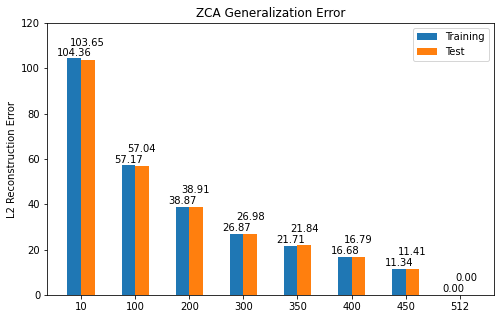

In [ ]:
plot_zca_train_test_err_by_layer_and_ncomp(err_by_ncomp)

### Comparison of Reconstruction Loss

In [ ]:
dvir_loss_by_layer = [127.35057926177979, 113.04265304565429, 102.86336795806885, 70.79206645965576, 52.69163465499878, 40.75720428466797, 31.91716977119446, 22.523408517837524, 14.459334473609925, 8.376384460926056]

In [ ]:
def plot_recon_loss_comparison(title, zca_loss_by_n_comp, bottleneck_loss_by_n_comp , filename=''):
  n_components_list_fine = [1,5,10,50,100,150,200,300,400,512]

  fig, ax = plt.subplots()
  ax.scatter(n_components_list_fine, zca_loss_by_n_comp, label="ZCA")
  ax.scatter(n_components_list_fine, bottleneck_loss_by_n_comp, label="Convolutional Bottleneck")
  ax.set_xlabel('Channel Capcity \ Components Retained')
  ax.set_ylabel('Mean L2 Reconstruction Error')
  ax.legend()
  fig.suptitle(title, fontsize=14)
  fig.set_size_inches(8, 5)
  if filename != '':
    plt.savefig(f'/content/plots/{filename}.png')
  plt.show()

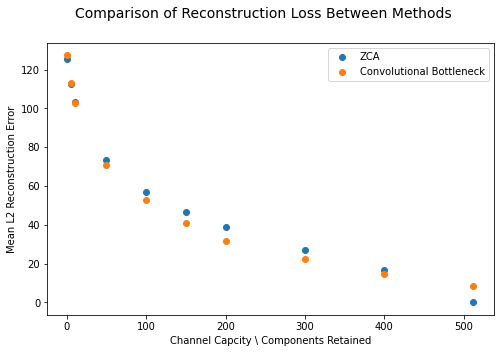

In [ ]:
  zca_parsed = [err[0][0] for err in err_by_layer_by_ncomp_fine.values()]
  zca_parsed.reverse()
  title = "Comparison of Reconstruction Loss Between Methods"
  plot_recon_loss_comparison(title, zca_parsed, dvir_loss_by_layer, 'recon_comparison')

### PCA Error dumpyard

In [ ]:
test_activations = load_activation_mat('/content/test_activations', 1, 512)
test_activations_split = torch.stack(list(torch.tensor_split(test_activations, 512, dim=1)), dim=0)
t_a = test_activations_split[0].cpu().numpy()

In [ ]:
train_activations = load_activation_mat(activation_dir, 1)
train_activations_split = torch.stack(list(torch.tensor_split(train_activations, 2048, dim=1)), dim=0)
train_a = test_activations_split[0].cpu().numpy()

In [ ]:
train_activations.shape

(131072, 512)

In [ ]:
from sklearn.decomposition import PCA
from numpy.linalg import norm

# test_activations = test_activations
# train_activations = train_activations
batch_size = train_activations.shape[1]*256
pca = PCA(512)
pca.fit(train_activations)

PCA(n_components=512)

In [ ]:
pca_r = PCA(300, svd_solver='full')
pca_r.fit(train_activations)

PCA(n_components=300, svd_solver='full')

In [ ]:
np.cumsum(pca.explained_variance_ratio_)[490]

0.9990066005695005

In [ ]:
trans_r = pca_r.transform(train_activations)
trans = pca.transform(train_activations)

In [ ]:
err = train_activations - pca_r.inverse_transform(pca_r.transform(train_activations))
err

array([[-0.08697284,  0.09713456,  0.01924857, ...,  0.05441174,
         0.0690708 ,  0.0680006 ],
       [-0.24436489,  0.22170725, -0.02319208, ..., -0.03408749,
         0.09641608,  0.06299502],
       [-0.20787257,  0.15708852, -0.02653241, ...,  0.02644802,
         0.13899757,  0.08737089],
       ...,
       [-0.14326897, -0.10783819, -0.07150733, ...,  0.05010094,
         0.08165073, -0.0799025 ],
       [-0.06618552, -0.25889558, -0.17332232, ...,  0.11113705,
         0.04907542, -0.04926243],
       [ 0.23402016, -0.27494618, -0.16961683, ...,  0.03521043,
         0.00691122,  0.00992608]], dtype=float32)

In [ ]:
norm(err, ord='fro') / norm(train_activations, ord='fro')

0.18605827

In [ ]:
transformed = pca.transform(t_a.T)

In [ ]:
decoded = pca.inverse_transform(transformed)

In [ ]:
diff = (t_a.T - decoded)

In [ ]:
np.linalg.norm(diff)

20.737939757442884

In [ ]:
train_dec = pca.inverse_transform(pca.transform(train_a.T))

In [ ]:
np.linalg.norm(train_a.T - train_dec)

20.737939757442884

In [ ]:
np.sum(pca_by_layer[0].singular_values_)

82454.76078766685

In [ ]:
error = np.linalg.norm(activation_mat - pca.inverse_transform(pca.transform(activation_mat)), ord='fro')

In [ ]:
org_nrom = np.linalg.norm(activation_mat, ord='fro')

In [ ]:
error / org_nrom

0.1849801842784336

In [ ]:
percent_err_by_layer_by_ncomp_fine = {key: [(err[0], 100*err[1]) for err in errs] for key, errs in err_by_layer_by_ncomp_fine.items()}

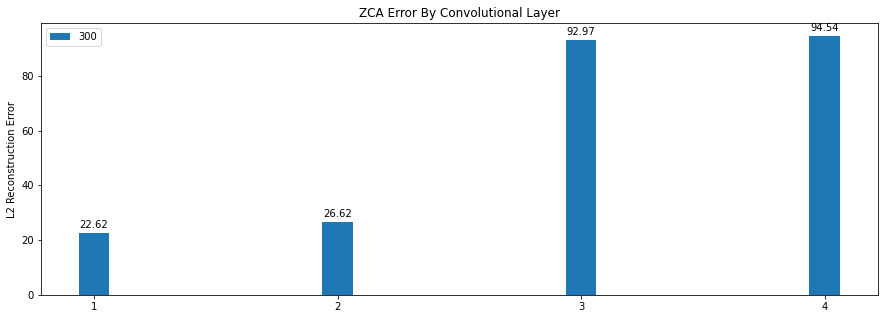

In [ ]:
plot_zca_err_by_layer_and_ncomp(l_indices, n_components_list_fine, percent_err_by_layer_by_ncomp_fine)

### Visual Results

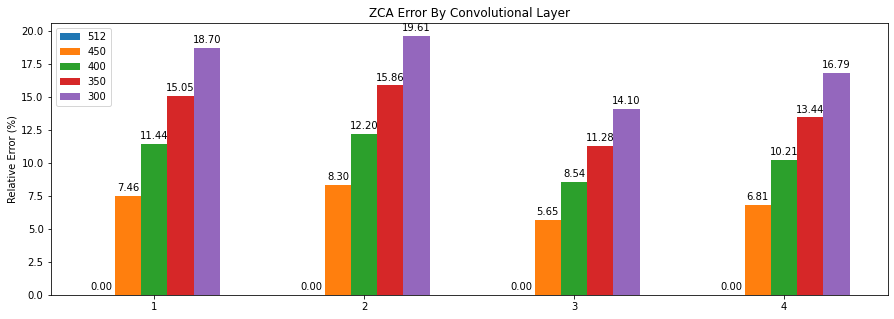

In [ ]:
plot_zca_rel_err_by_layer_and_ncomp(l_indices, n_components_list_fine, percent_err_by_layer_by_ncomp_fine)

In [ ]:
err_by_layer_by_ncomp_fine

In [ ]:
!cp /content/drive/MyDrive/dvir_samples_good.zip /content

In [ ]:
!unzip ./dvir_samples_good.zip

In [ ]:
import torch
from PIL import Image
from torchvision.utils import make_grid
from torchvision import transforms

# Shows the tensor as an image.
@torch.no_grad()
def show_images(tensors, nrow =1) -> None:
    tensors = [t.permute(1, 2, 0) for t in tensors]
    grid=make_grid(tensors, nrow=nrow, padding=0)
    to_numpy=grid.to("cpu", torch.uint8).numpy()
    grid_image = Image.fromarray(to_numpy)
    return grid_image

# Takes a batch of tenstors and return the batch as images.
def tensor_to_image_tensor(tensor):
    for i in range(tensor.size(0)):
        tensor[i] -= torch.min(tensor[i])
        tensor[i] /= torch.max(tensor[i])
    tensor.mul_(255).add_(0.5).clamp_(0, 255)
    return tensor

components_list = [0,512,300,100,50,10,5,1]
convert_tensor = transforms.ToTensor()
for i in range(10):
  imgs = [Image.open(f"/content/stylegan2-pytorch/dvir_samples/{c}/{str(i).zfill(6)}.png") for c in components_list]
  tensors = [tensor_to_image_tensor(convert_tensor(img)) for img in imgs]
  grid = show_images(tensors)
  grid.show()
  grid.save(f"/content/grids/{str(i).zfill(6)}.png")

In [ ]:
components_list = [0,512,400,300,100,50,10,5,1]
convert_tensor = transforms.ToTensor()
for i in range(10):
  imgs = [Image.open(f"/content/dvir_samples/{c}/{str(i).zfill(6)}.png") for c in components_list]
  tensors = [tensor_to_image_tensor(convert_tensor(img)) for img in imgs]
  grid = show_images(tensors)
  grid.show()
  grid.save(f"/content/grids/{str(i).zfill(6)}.png")

In [ ]:
!zip -r dvir_grids.zip grids/
!cp dvir_grids.zip /content/drive/MyDrive/